# Allgemine Analyse

*Kai, Andrew und Fabian*

---

## 1. Bestimmung der Integrationsordnung

- Augmented Dickey-Fuller Test (ADF-Test)
- Phillips-Perron Test (PP-Test)
- Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS-Test)


## 2. Transformation zur Stationarität

- Differenzierung
- Erste Differenz: $y_t - y_{t-1}$
- Zweite Differenz: $(y_t - y_{t-1}) - (y_{t-1} - y_{t-2})$
- Logarithmische Transformation
- Moving Average
- Simple Exponential Smoothing
- HP-Filter (Hodrick-Prescott-Filter)


## 3. ACF und PACF Analyse

- Autokorrelationsfunktion (ACF)
- Partielle Autokorrelationsfunktion (PACF)


## 4. Modellspezifikation

- AR-Modelle (Autoregressive)
- MA-Modelle (Moving Average)
- ARMA-Modelle
- ARIMA-Modelle
- Auto-ARIMA-Modell

In [35]:
########################################################
#--------------------- Librarys -----------------------#
########################################################

import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller, kpss
import statsmodels.api as sm
from arch.unitroot import ADF, KPSS, PhillipsPerron
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.filters.hp_filter import hpfilter
from statsmodels.tsa.holtwinters import SimpleExpSmoothing
from pmdarima.arima import auto_arima
from scipy import stats
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.stats.stattools import jarque_bera
import os
import warnings

In [25]:
########################################################
#------------------- data Import ----------------------#
########################################################

samsung_data = pd.read_csv(os.path.join("../data", "005930.ks_aktien_daten.csv"))
daimler_data = pd.read_csv(os.path.join("../data", "mbg.de_aktien_daten.csv"))
microsoft_data = pd.read_csv(os.path.join("../data", "msft_aktien_daten.csv"))

---

---

## **1. Bestimmung der Integrationsordnung**

- Augmented Dickey-Fuller Test (ADF-Test)
- Phillips-Perron Test (PP-Test)
- Kwiatkowski-Phillips-Schmidt-Shin Test (KPSS-Test)

In [26]:
########################################################
#-----------------------   1.   -----------------------#
#--------- Bestimmung der Integrationsordnung ---------#
########################################################

def stationaritaets_tests(zeitreihe, zeitreihen_name="Zeitreihe"):
    """
    Führt ADF-, KPSS- und Phillips-Perron-Test für eine Zeitreihe durch,
    alle implementiert mit der arch.unitroot Bibliothek.
    
    Parameter:
    -----------
    zeitreihe : pandas.Series oder array-like
        Die Zeitreihendaten, die auf Stationarität getestet werden sollen
    zeitreihen_name : str, optional
        Name der Zeitreihe für die Übersichtlichkeit der Ausgabe
    
    Rückgabe:
    --------
    dict
        Dictionary mit Testergebnissen mit den Schlüsseln 'adf', 'kpss' und 'pp'
    """
    ergebnisse = {}
    
    # Stellen wir sicher, dass wir mit einer bereinigten Zeitreihe arbeiten (keine NaN-Werte)
    bereinigte_reihe = pd.Series(zeitreihe).dropna()
    
    print(f"\n===== Stationaritätstests für {zeitreihen_name} =====\n")
    
    # ADF-Test mit arch.unitroot
    print("Augmented Dickey-Fuller Test (arch.unitroot):")
    try:
        adf = ADF(bereinigte_reihe)
        adf_ausgabe = pd.Series(
            [adf.stat, adf.pvalue, adf.lags, adf.nobs, 
             adf.critical_values['1%'], adf.critical_values['5%'], adf.critical_values['10%']],
            index=['Test-Statistik', 'p-Wert', 'Verwendete Lags', 'Anzahl der Beobachtungen', 
                   'Kritischer Wert (1%)', 'Kritischer Wert (5%)', 'Kritischer Wert (10%)']
        )
        print(adf_ausgabe)
        if adf.pvalue <= 0.05:
            print("Schlussfolgerung: Nullhypothese wird abgelehnt. Die Zeitreihe ist stationär.\n")
        else:
            print("Schlussfolgerung: Nullhypothese kann nicht abgelehnt werden. Die Zeitreihe ist nicht-stationär.\n")
        ergebnisse['adf'] = adf
    except Exception as e:
        print(f"Fehler beim ADF-Test: {e}\n")
        ergebnisse['adf'] = None
    
    # KPSS-Test mit arch.unitroot
    print("KPSS-Test (arch.unitroot):")
    try:
        kpss_test = KPSS(bereinigte_reihe)
        kpss_ausgabe = pd.Series(
            [kpss_test.stat, kpss_test.pvalue, kpss_test.lags, kpss_test.nobs, 
             kpss_test.critical_values['10%'], kpss_test.critical_values['5%'], 
             kpss_test.critical_values['2.5%'] if '2.5%' in kpss_test.critical_values else None, 
             kpss_test.critical_values['1%']],
            index=['Test-Statistik', 'p-Wert', 'Verwendete Lags', 'Anzahl der Beobachtungen', 
                   'Kritischer Wert (10%)', 'Kritischer Wert (5%)', 'Kritischer Wert (2.5%)', 
                   'Kritischer Wert (1%)']
        )
        print(kpss_ausgabe)
        if kpss_test.pvalue <= 0.05:
            print("Schlussfolgerung: Nullhypothese wird abgelehnt. Die Zeitreihe ist nicht-stationär.\n")
        else:
            print("Schlussfolgerung: Nullhypothese kann nicht abgelehnt werden. Die Zeitreihe ist stationär.\n")
        ergebnisse['kpss'] = kpss_test
    except Exception as e:
        print(f"Fehler beim KPSS-Test: {e}\n")
        ergebnisse['kpss'] = None
    
    # Phillips-Perron-Test mit arch.unitroot
    print("Phillips-Perron-Test (arch.unitroot):")
    try:
        pp = PhillipsPerron(bereinigte_reihe)
        pp_ausgabe = pd.Series(
            [pp.stat, pp.pvalue, pp.lags, pp.nobs, 
             pp.critical_values['1%'], pp.critical_values['5%'], pp.critical_values['10%']],
            index=['Test-Statistik', 'p-Wert', 'Verwendete Lags', 'Anzahl der Beobachtungen', 
                   'Kritischer Wert (1%)', 'Kritischer Wert (5%)', 'Kritischer Wert (10%)']
        )
        print(pp_ausgabe)
        if pp.pvalue <= 0.05:
            print("Schlussfolgerung: Nullhypothese wird abgelehnt. Die Zeitreihe ist stationär.\n")
        else:
            print("Schlussfolgerung: Nullhypothese kann nicht abgelehnt werden. Die Zeitreihe ist nicht-stationär.\n")
        ergebnisse['pp'] = pp
    except Exception as e:
        print(f"Fehler beim Phillips-Perron-Test: {e}\n")
        ergebnisse['pp'] = None
    
    return ergebnisse


########################################################
#------------ Stationaritätstests anwenden ------------#
########################################################

# Annahme: Die Daten sind bereits geladen
# Stellen wir sicher, dass wir die Spalte "Close" für jeden Datensatz verwenden
samsung_reihe = samsung_data["Close"]
daimler_reihe = daimler_data["Close"]
microsoft_reihe = microsoft_data["Close"]

# Tests für jeden Datensatz durchführen
samsung_ergebnisse = stationaritaets_tests(samsung_reihe, "Samsung")
daimler_ergebnisse = stationaritaets_tests(daimler_reihe, "Daimler")
microsoft_ergebnisse = stationaritaets_tests(microsoft_reihe, "Microsoft")


===== Stationaritätstests für Samsung =====

Augmented Dickey-Fuller Test (arch.unitroot):
Test-Statistik                -0.716291
p-Wert                         0.842485
Verwendete Lags               28.000000
Anzahl der Beobachtungen    6318.000000
Kritischer Wert (1%)          -3.431385
Kritischer Wert (5%)          -2.861998
Kritischer Wert (10%)         -2.567014
dtype: float64
Schlussfolgerung: Nullhypothese kann nicht abgelehnt werden. Die Zeitreihe ist nicht-stationär.

KPSS-Test (arch.unitroot):
Test-Statistik                11.588162
p-Wert                         0.000100
Verwendete Lags               46.000000
Anzahl der Beobachtungen    6347.000000
Kritischer Wert (10%)          0.347500
Kritischer Wert (5%)           0.461400
Kritischer Wert (2.5%)              NaN
Kritischer Wert (1%)           0.742800
dtype: float64
Schlussfolgerung: Nullhypothese wird abgelehnt. Die Zeitreihe ist nicht-stationär.

Phillips-Perron-Test (arch.unitroot):
Test-Statistik                -0

---

---

## 2. Transformation zur Stationarität

- Differenzierung
- Erste Differenz: $y_t - y_{t-1}$
- Zweite Differenz: $(y_t - y_{t-1}) - (y_{t-1} - y_{t-2})$
- Logarithmische Transformation
- Moving Average
- Simple Exponential Smoothing
- HP-Filter (Hodrick-Prescott-Filter)

In [27]:
def stationaritaets_transformationen(zeitreihe, name):
    """
    Führt verschiedene Transformationen zur Stationarität auf einer Zeitreihe durch.
    
    Parameter:
    -----------
    zeitreihe : pandas.Series
        Die zu transformierende Zeitreihe
    name : str
        Name der Zeitreihe für die Benennung der Ausgabevariablen
    
    Rückgabe:
    --------
    dict
        Dictionary mit allen transformierten Zeitreihen
    """
    transformiert = {}
    
    # Originale Zeitreihe speichern
    transformiert[f"{name}_original"] = zeitreihe
    
    # 1. Differenzierung
    # Erste Differenz
    transformiert[f"{name}_diff1"] = zeitreihe.diff().dropna()
    
    # Zweite Differenz
    transformiert[f"{name}_diff2"] = transformiert[f"{name}_diff1"].diff().dropna()
    
    # 2. Logarithmische Transformation
    # Prüfen, ob alle Werte > 0 sind für Log-Transformation
    if all(zeitreihe > 0):
        # Log-Transformation
        transformiert[f"{name}_log"] = np.log(zeitreihe)
        
        # 3. Log-Differenz (Wachstumsrate)
        transformiert[f"{name}_log_diff"] = transformiert[f"{name}_log"].diff().dropna()
    else:
        print(f"Log-Transformation für {name} nicht möglich, da negative oder Null-Werte vorhanden sind.")
    
    # 4. Moving Average
    # Wähle eine geeignete Fensterlänge für MA
    window = 20
    transformiert[f"{name}_ma"] = zeitreihe.rolling(window=window).mean().dropna()
    
    # Differenz zum MA
    ma_temp = zeitreihe.rolling(window=window).mean()
    transformiert[f"{name}_ma_diff"] = (zeitreihe - ma_temp).dropna()
    
    # 5. Simple Exponential Smoothing
    # Optimal Alpha durch Optimierung finden
    try:
        optimal_model = SimpleExpSmoothing(zeitreihe).fit(optimized=True)
        ses_optimal = optimal_model.fittedvalues
        transformiert[f"{name}_ses"] = ses_optimal
        transformiert[f"{name}_ses_diff"] = zeitreihe - ses_optimal
    except:
        print(f"SES für {name} konnte nicht berechnet werden.")
    
    # 6. HP-Filter
    # Für tägliche Daten (Aktienkurse)
    lambda_param = 129600
    
    try:
        cycle, trend = hpfilter(zeitreihe, lamb=lambda_param)
        transformiert[f"{name}_hp_trend"] = trend
        transformiert[f"{name}_hp_cycle"] = cycle
    except Exception as e:
        print(f"HP-Filter für {name} konnte nicht angewendet werden: {e}")
    
    return transformiert

# Funktion anwenden auf alle drei Zeitreihen
def alle_zeitreihen_transformieren(samsung_data, daimler_data, microsoft_data):
    # Stellen wir sicher, dass wir mit der Spalte "Close" arbeiten
    samsung_reihe = samsung_data["Close"]
    daimler_reihe = daimler_data["Close"]
    microsoft_reihe = microsoft_data["Close"]
    
    # Transformationen für jede Zeitreihe berechnen
    samsung_trans = stationaritaets_transformationen(samsung_reihe, "samsung")
    daimler_trans = stationaritaets_transformationen(daimler_reihe, "daimler")
    microsoft_trans = stationaritaets_transformationen(microsoft_reihe, "microsoft")
    
    # Alle Transformationen in ein Dictionary zusammenfassen
    alle_transformationen = {
        "samsung": samsung_trans,
        "daimler": daimler_trans,
        "microsoft": microsoft_trans
    }
    
    return alle_transformationen

transformationen = alle_zeitreihen_transformieren(samsung_data, daimler_data, microsoft_data)

/Users/kaihufnagel/Library/Python/3.9/lib/python/site-packages/statsmodels/tsa/holtwinters/model.py:915: ConvergenceWarning: Optimization failed to converge. Check mle_retvals.
  warnings.warn(


In [28]:
def teste_vorhandene_transformationen(transformationen):
    """
    Führt Stationaritätstests für bereits transformierte Zeitreihen durch
    
    Parameter:
    -----------
    transformationen : dict
        Dictionary mit transformierten Zeitreihen, wie von alle_zeitreihen_transformieren() zurückgegeben
    """
    # Durchlaufe jede Aktie
    for aktie_name, trans_dict in transformationen.items():
        print(f"\n{'='*50}")
        print(f"TESTS FÜR {aktie_name.upper()}")
        print(f"{'='*50}")
        
        # Durchlaufe jede Transformation dieser Aktie
        for trans_name, zeitreihe in trans_dict.items():
            # Erstelle einen sauberen Anzeigenamen
            display_name = f"{aktie_name} | {trans_name.replace(f'{aktie_name}_', '')}"
            
            print(f"\n{'-'*15} {display_name} {'-'*15}")
            
            # Führe die Stationaritätstests durch
            stationaritaets_tests(zeitreihe, display_name)

teste_vorhandene_transformationen(transformationen)


TESTS FÜR SAMSUNG

--------------- samsung | original ---------------

===== Stationaritätstests für samsung | original =====

Augmented Dickey-Fuller Test (arch.unitroot):
Test-Statistik                -0.716291
p-Wert                         0.842485
Verwendete Lags               28.000000
Anzahl der Beobachtungen    6318.000000
Kritischer Wert (1%)          -3.431385
Kritischer Wert (5%)          -2.861998
Kritischer Wert (10%)         -2.567014
dtype: float64
Schlussfolgerung: Nullhypothese kann nicht abgelehnt werden. Die Zeitreihe ist nicht-stationär.

KPSS-Test (arch.unitroot):
Test-Statistik                11.588162
p-Wert                         0.000100
Verwendete Lags               46.000000
Anzahl der Beobachtungen    6347.000000
Kritischer Wert (10%)          0.347500
Kritischer Wert (5%)           0.461400
Kritischer Wert (2.5%)              NaN
Kritischer Wert (1%)           0.742800
dtype: float64
Schlussfolgerung: Nullhypothese wird abgelehnt. Die Zeitreihe ist nicht-

---

## Stationäre Lof Diff Zeitreihen:

#### **Output:**

## **samsung | log_diff**

===== Stationaritätstests für samsung | log_diff =====

##### **Augmented Dickey-Fuller Test (arch.unitroot):**

p-Wert                         0.000000

**Schlussfolgerung:** Nullhypothese wird abgelehnt. Die Zeitreihe ist stationär.


##### **KPSS-Test (arch.unitroot):**

p-Wert                         0.956299

**Schlussfolgerung:** Nullhypothese kann nicht abgelehnt werden. Die Zeitreihe ist stationär.


##### **Phillips-Perron-Test (arch.unitroot):**

p-Wert                         0.000000

**Schlussfolgerung:** Nullhypothese wird abgelehnt. Die Zeitreihe ist stationär.


---

## **daimler | log_diff**

===== Stationaritätstests für daimler | log_diff =====

##### **Augmented Dickey-Fuller Test (arch.unitroot):**

p-Wert                      1.052025e-27

**Schlussfolgerung:** Nullhypothese wird abgelehnt. Die Zeitreihe ist stationär.


##### **KPSS-Test (arch.unitroot):**

p-Wert                         0.946683

**Schlussfolgerung:** Nullhypothese kann nicht abgelehnt werden. Die Zeitreihe ist stationär.


##### **Phillips-Perron-Test (arch.unitroot):**

p-Wert                         0.000000

**Schlussfolgerung:** Nullhypothese wird abgelehnt. Die Zeitreihe ist stationär.


---

### **microsoft | log_diff**

===== Stationaritätstests für microsoft | log_diff =====

##### **Augmented Dickey-Fuller Test (arch.unitroot):**

p-Wert                         0.000000

**Schlussfolgerung:** Nullhypothese wird abgelehnt. Die Zeitreihe ist stationär.


##### **KPSS-Test (arch.unitroot):**

p-Wert                         0.043272

**Schlussfolgerung:** Nullhypothese wird abgelehnt. Die Zeitreihe ist nicht-stationär.


##### **Phillips-Perron-Test (arch.unitroot):**

p-Wert                         0.000000

**Schlussfolgerung:** Nullhypothese wird abgelehnt. Die Zeitreihe ist stationär.

---

---

## 3. ACF und PACF Analyse

- Autokorrelationsfunktion (ACF)
- Partielle Autokorrelationsfunktion (PACF)

In [29]:
def acf_pacf_werte(transformationen, transformation_typ="log_diff"):
    """
    Berechnet ACF und PACF Werte für eine bestimmte Transformation aller Zeitreihen.
    
    Parameter:
    -----------
    transformationen : dict
        Dictionary mit transformierten Zeitreihen
    transformation_typ : str
        Typ der Transformation zu analysieren
    """
    
    ergebnisse = {}
    
    # Durchlaufe jede Aktie
    for aktie_name in ['samsung', 'daimler', 'microsoft']:
        if aktie_name in transformationen:
            trans_key = f"{aktie_name}_{transformation_typ}"
            
            if trans_key in transformationen[aktie_name]:
                zeitreihe = transformationen[aktie_name][trans_key]
                
                # Berechne ACF und PACF
                acf_values = acf(zeitreihe, nlags=40, fft=False)
                pacf_values = pacf(zeitreihe, nlags=40, method='ols')
                
                ergebnisse[aktie_name] = {
                    'acf': acf_values,
                    'pacf': pacf_values
                }
                
                print(f"\n{aktie_name.upper()} - {transformation_typ}")
                print("ACF:", [f"{val:.4f}" for val in acf_values[:10]])
                print("PACF:", [f"{val:.4f}" for val in pacf_values[:10]])
                
                # Bewertung der Stationarität basierend auf ACF/PACF
                # ACF sollte schnell gegen 0 gehen für stationäre Zeitreihen
                acf_schnell_abfallend = all(abs(val) < 0.1 for val in acf_values[5:10])
                
                # Signifikante PACF Lags finden (für ARIMA Parameter)
                pacf_signifikant = [i for i, val in enumerate(pacf_values[1:6], 1) if abs(val) > 0.1]
                acf_signifikant = [i for i, val in enumerate(acf_values[1:6], 1) if abs(val) > 0.1]
                
                # Bewertung ausgeben
                if acf_schnell_abfallend:
                    print("✓ ACF fällt schnell ab - Zeitreihe scheint stationär")
                else:
                    print("✗ ACF fällt langsam ab - möglicherweise nicht vollständig stationär")
                
                if pacf_signifikant:
                    print(f"→ Vorgeschlagenes p (AR-Parameter): {max(pacf_signifikant)}")
                else:
                    print("→ Kein klares p (AR-Parameter) erkennbar")
                
                if acf_signifikant:
                    print(f"→ Vorgeschlagenes q (MA-Parameter): {max(acf_signifikant)}")
                else:
                    print("→ Kein klares q (MA-Parameter) erkennbar")
    
    return ergebnisse

acf_pacf_werte(transformationen, "log_diff")


SAMSUNG - log_diff
ACF: ['1.0000', '0.0396', '-0.0625', '-0.0426', '-0.0421', '-0.0100', '0.0028', '-0.0025', '-0.0046', '-0.0018']
PACF: ['1.0000', '0.0396', '-0.0642', '-0.0376', '-0.0432', '-0.0117', '-0.0034', '-0.0073', '-0.0071', '-0.0030']
✓ ACF fällt schnell ab - Zeitreihe scheint stationär
→ Kein klares p (AR-Parameter) erkennbar
→ Kein klares q (MA-Parameter) erkennbar

DAIMLER - log_diff
ACF: ['1.0000', '0.0351', '-0.0047', '-0.0167', '0.0207', '-0.0264', '-0.0418', '0.0251', '0.0060', '-0.0095']
PACF: ['1.0000', '0.0351', '-0.0060', '-0.0163', '0.0219', '-0.0282', '-0.0401', '0.0286', '0.0023', '-0.0100']
✓ ACF fällt schnell ab - Zeitreihe scheint stationär
→ Kein klares p (AR-Parameter) erkennbar
→ Kein klares q (MA-Parameter) erkennbar

MICROSOFT - log_diff
ACF: ['1.0000', '-0.0176', '-0.0384', '-0.0285', '-0.0235', '0.0104', '-0.0031', '0.0112', '-0.0117', '0.0182']
PACF: ['1.0000', '-0.0176', '-0.0387', '-0.0300', '-0.0262', '0.0072', '-0.0056', '0.0103', '-0.0117', '0

{'samsung': {'acf': array([ 1.        ,  0.03961741, -0.06246157, -0.04259913, -0.04209461,
         -0.00998218,  0.00277057, -0.00252515, -0.0046237 , -0.00176353,
         -0.01022026,  0.00882318, -0.00562351, -0.01283562, -0.00294778,
         -0.00632496,  0.01162141,  0.01339745,  0.03073378,  0.03717625,
         -0.02375663, -0.01085997, -0.02276112,  0.0038908 ,  0.02545009,
         -0.01269233,  0.00596305,  0.01175447, -0.00149705,  0.02235109,
          0.03727539,  0.00634279, -0.03352487,  0.00454714, -0.0254239 ,
          0.01053475,  0.0093392 ,  0.01408287, -0.03186915, -0.0122001 ,
          0.01890005]),
  'pacf': array([ 1.00000000e+00,  3.96194905e-02, -6.42108919e-02, -3.76081643e-02,
         -4.32290277e-02, -1.17224239e-02, -3.36921794e-03, -7.29863343e-03,
         -7.05117399e-03, -2.99735467e-03, -1.13388086e-02,  8.65754214e-03,
         -8.58345932e-03, -1.23774605e-02, -3.26985899e-03, -7.92624246e-03,
          1.02493769e-02,  1.00987660e-02,  3.0334

---

---

## Auto ARIMA


SAMSUNG:
  Bestes Modell: (2, 0, 1)


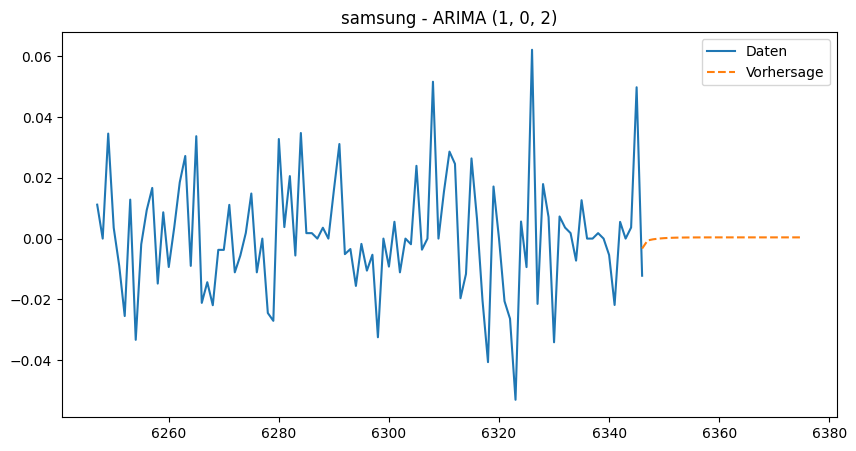


DAIMLER:
  Bestes Modell: (0, 0, 1)


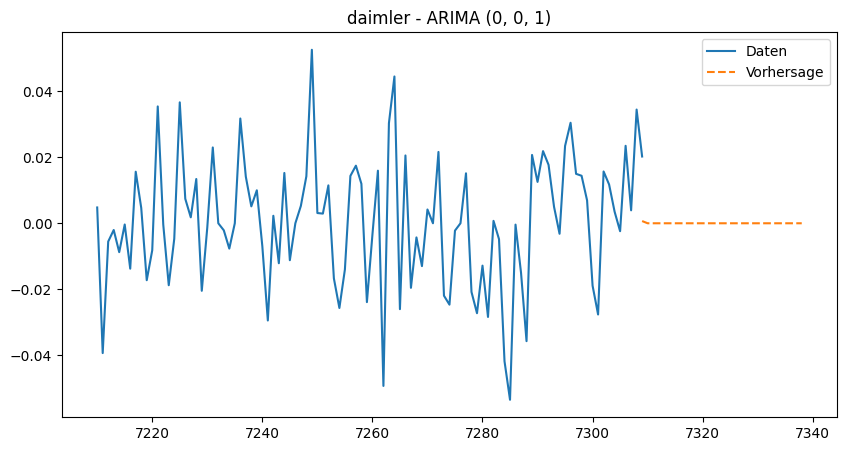


MICROSOFT:


In [ ]:
warnings.filterwarnings('ignore')
def auto_arima_simple(transformationen, transformation_typ="log_diff"):
    """
    Erstellt Auto-ARIMA Modelle für alle Zeitreihen mit Expanding Window.
    """
    ergebnisse = {}
    
    for aktie_name in ['samsung', 'daimler', 'microsoft']:
        trans_key = f"{aktie_name}_{transformation_typ}"
        
        if aktie_name in transformationen and trans_key in transformationen[aktie_name]:
            zeitreihe = transformationen[aktie_name][trans_key]
            
            print(f"\n{aktie_name.upper()}:")
            
            # Expanding Window: 40% train, 15% test, dann erweitern
            n = len(zeitreihe)
            train_size = int(0.4 * n)
            test_size = int(0.15 * n)
            
            models = []
            test_errors = []
            
            # Mehrere Windows testen
            for i in range(3):  # 3 Windows
                if train_size + test_size <= n:
                    train_data = zeitreihe.iloc[:train_size]
                    test_data = zeitreihe.iloc[train_size:train_size + test_size]
                    
                    # Auto-ARIMA
                    model = auto_arima(train_data, d=0, max_p=10, max_q=10, 
                                     seasonal=False, suppress_warnings=True)
                    
                    # Test error
                    test_pred = model.predict(n_periods=len(test_data))
                    test_mse = ((test_data - test_pred) ** 2).mean()
                    
                    models.append(model)
                    test_errors.append(test_mse)
                    
                    train_size += test_size
            
            # Bestes Modell
            best_model = models[test_errors.index(min(test_errors))]
            print(f"  Bestes Modell: {best_model.order}")
            
            # Finale Vorhersage auf allen Daten
            final_model = auto_arima(zeitreihe, max_d=10, max_p=10, max_q=10, 
                                   seasonal=False, suppress_warnings=True)
            forecast = final_model.predict(n_periods=30)
            
            # Plot
            plt.figure(figsize=(10, 5))
            plt.plot(zeitreihe.iloc[-100:], label='Daten')
            plt.plot(range(len(zeitreihe), len(zeitreihe) + 30), forecast, 
                    label='Vorhersage', linestyle='--')
            plt.title(f'{aktie_name} - ARIMA {final_model.order}')
            plt.legend()
            plt.show()
            
            ergebnisse[aktie_name] = {
                'model': final_model,
                'forecast': forecast
            }
    
    return ergebnisse

# Verwendung
arima_ergebnisse = auto_arima_simple(transformationen, "log_diff")

## AR & MA Modell Aufbau
---



---

## 5. Modelldiagnose

### Ljung-Box Test (Portmanteau Test)

### Jarque-Bera Test

### Residuenanalyse


In [50]:
def residual_analysis(arima_ergebnisse):
    """
    Analysiert die Residuen von ARIMA Modellen
    
    Parameters:
    arima_ergebnisse: dict mit ARIMA models und forecasts (Output von auto_arima_simple)
    """
    
    results = {}
    
    fig, axes = plt.subplots(3, 3, figsize=(15, 10))
    fig.suptitle('Residuenanalyse der ARIMA Modelle', fontsize=16)
    
    aktien = ['samsung', 'daimler', 'microsoft']
    
    for i, aktie_name in enumerate(aktien):
        if aktie_name in arima_ergebnisse:
            model = arima_ergebnisse[aktie_name]['model']
            
            # Residuen extrahieren
            residuals = model.resid()
            
            # 1. Ljung-Box Test (Autokorrelation)
            ljung_box = acorr_ljungbox(residuals, lags=10, return_df=True)
            
            # 2. Jarque-Bera Test (Normalverteilung)
            jb_stat, jb_pvalue, _, _ = jarque_bera(residuals)
            
            # Ergebnisse speichern
            results[aktie_name] = {
                'ljung_box_pvalue': ljung_box['lb_pvalue'].iloc[-1],
                'jb_pvalue': jb_pvalue,
                'residuals_mean': residuals.mean(),
                'residuals_std': residuals.std()
            }
            
            # 3. Visualisierungen
            # Residuen Plot
            axes[i, 0].plot(residuals)
            axes[i, 0].set_title(f'{aktie_name.upper()} - Residuen')
            axes[i, 0].axhline(y=0, color='r', linestyle='--')
            
            # QQ-Plot
            stats.probplot(residuals, dist="norm", plot=axes[i, 1])
            axes[i, 1].set_title(f'{aktie_name.upper()} - Q-Q Plot')
            
            # Histogram
            axes[i, 2].hist(residuals, bins=30, density=True, alpha=0.7)
            axes[i, 2].set_title(f'{aktie_name.upper()} - Histogram')
            
            # Normalverteilung überlagern
            x = np.linspace(residuals.min(), residuals.max(), 100)
            axes[i, 2].plot(x, stats.norm.pdf(x, residuals.mean(), residuals.std()), 'r-')
    
    plt.tight_layout()
    plt.show()
    
    # Zusammenfassung der Tests
    print("\n" + "="*60)
    print("RESIDUENANALYSE - ZUSAMMENFASSUNG")
    print("="*60)
    
    for aktie_name, result in results.items():
        print(f"\n{aktie_name.upper()}:")
        print(f"  Ljung-Box Test (p-Wert): {result['ljung_box_pvalue']:.4f}")
        print(f"  → {'✓ Keine Autokorrelation' if result['ljung_box_pvalue'] > 0.05 else '✗ Autokorrelation vorhanden'}")
        
        print(f"  Jarque-Bera Test (p-Wert): {result['jb_pvalue']:.4f}")
        print(f"  → {'✓ Normalverteilung' if result['jb_pvalue'] > 0.05 else '✗ Keine Normalverteilung'}")
        
        print(f"  Residuen Mittelwert: {result['residuals_mean']:.6f}")
        print(f"  Residuen Std: {result['residuals_std']:.4f}")
    
    print("\n" + "="*60)
    print("INTERPRETATION:")
    print("- Ljung-Box Test: p > 0.05 → Residuen sind unkorreliert (gut)")
    print("- Jarque-Bera Test: p > 0.05 → Residuen sind normalverteilt (gut)")
    print("- Residuen sollten um 0 schwanken mit konstanter Varianz")
    print("="*60)
    
    return results

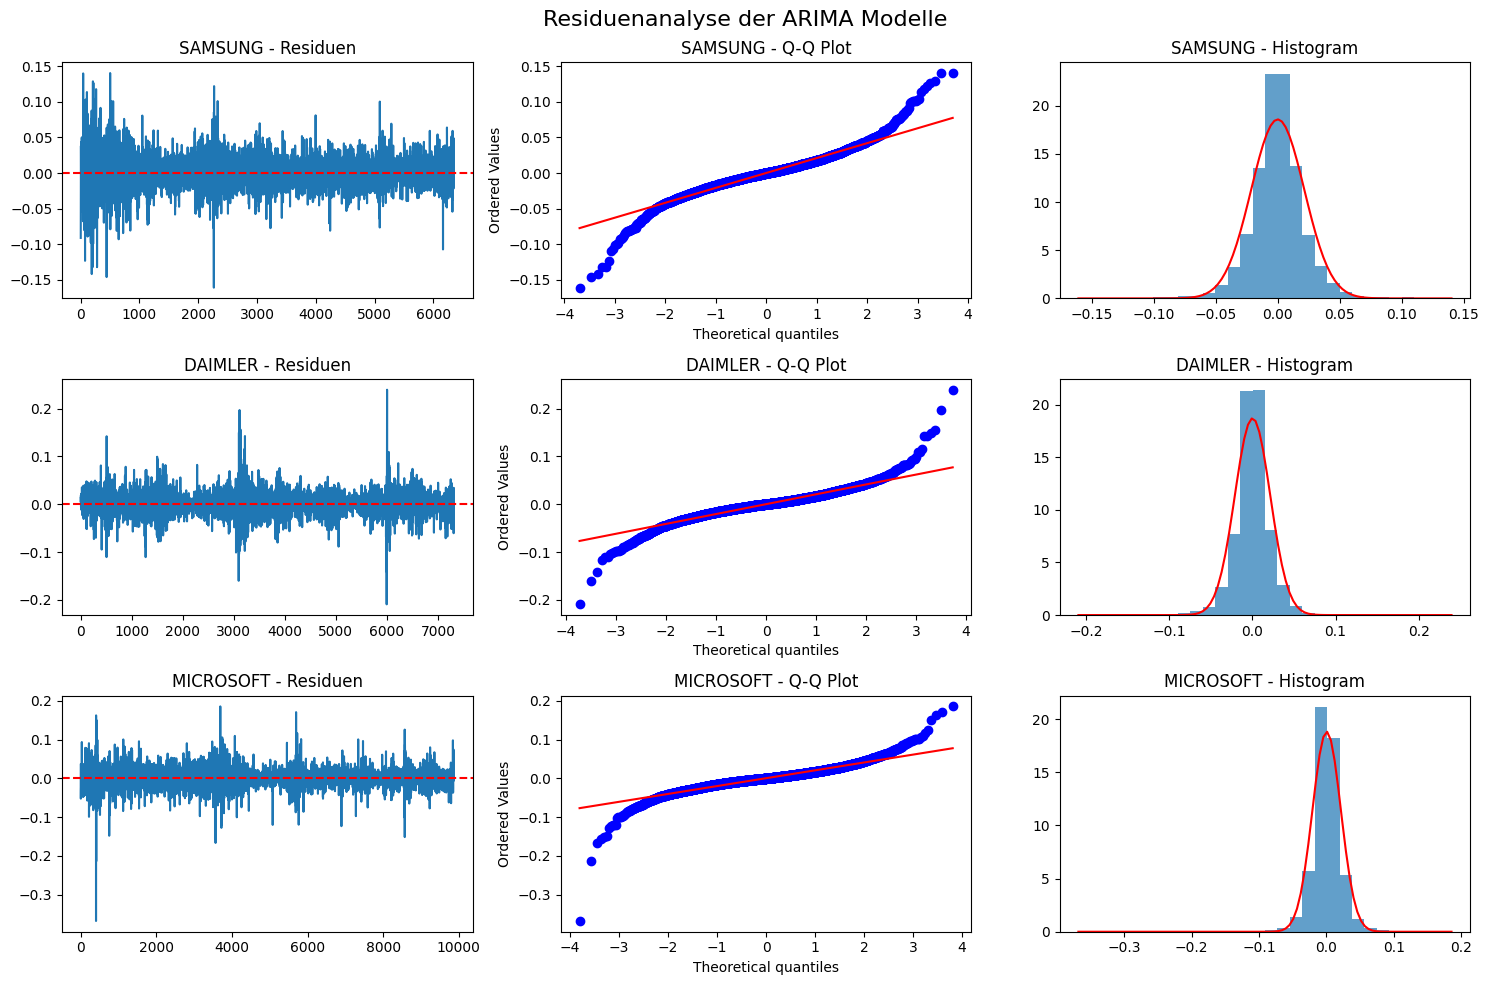


RESIDUENANALYSE - ZUSAMMENFASSUNG

SAMSUNG:
  Ljung-Box Test (p-Wert): 0.9722
  → ✓ Keine Autokorrelation
  Jarque-Bera Test (p-Wert): 0.0000
  → ✗ Keine Normalverteilung
  Residuen Mittelwert: 0.000002
  Residuen Std: 0.0215

DAIMLER:
  Ljung-Box Test (p-Wert): 0.0470
  → ✗ Autokorrelation vorhanden
  Jarque-Bera Test (p-Wert): 0.0000
  → ✗ Keine Normalverteilung
  Residuen Mittelwert: 0.000214
  Residuen Std: 0.0213

MICROSOFT:
  Ljung-Box Test (p-Wert): 0.0000
  → ✗ Autokorrelation vorhanden
  Jarque-Bera Test (p-Wert): 0.0000
  → ✗ Keine Normalverteilung
  Residuen Mittelwert: 0.000447
  Residuen Std: 0.0212

INTERPRETATION:
- Ljung-Box Test: p > 0.05 → Residuen sind unkorreliert (gut)
- Jarque-Bera Test: p > 0.05 → Residuen sind normalverteilt (gut)
- Residuen sollten um 0 schwanken mit konstanter Varianz


In [51]:
residual_results = residual_analysis(arima_ergebnisse)